In [49]:
import dataclasses
from dataclasses import dataclass
from enum import Enum
from pathlib import Path
from typing import List

from IPython.display import display, JSON
import ipywidgets as widgets
import pandas as pd
import plotly.graph_objects as go
from ruamel.yaml import YAML

from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_france import FranceTaxBenefitSystem

ModuleNotFoundError: No module named 'pandas'

## Initialize tax and benefit system of France

In [4]:
tax_benefit_system = FranceTaxBenefitSystem()

## Precalculate "revenu disponible"

In [5]:
def count_to_step(min, max, count):
    """Examples:
    >>> count_to_step(0, 80, 5)
    20
    """
    return float(max - min) / (count - 1)

def value_to_index(min, step, value):
    """Examples:
    >>> value_to_index(0, 10, 0)
    0
    >>> value_to_index(0, 10, 40)
    4
    >>> value_to_index(3, 1, 6)
    3
    """
    return int((value / step) - min)

In [6]:
COUNT = 20
MIN = 0
MAX = 500000
STEP = count_to_step(MIN, MAX, COUNT)
INITIAL_VALUE = 0
PERIOD = "2019"

In [7]:
test_case = {
    "individus": {
        "Michel": {
            'date_naissance': {'ETERNITY': '1980-01-01'},
        },
    },
    "familles": {
        "famille_1": {
            "parents": ["Michel"]
        }
    },
    "foyers_fiscaux": {
        "foyer_fiscal_1": {
            "declarants": ["Michel"],
        },
    },
    "menages": {
        "menage_1": {
            "personne_de_reference": ["Michel"],
        }},
    "axes": [[
        {
            "name": 'salaire_de_base',
            "count": COUNT,
            "min": MIN,
            "max": MAX,
            "period": PERIOD,
        },
    ]],
}


In [8]:
simulation_builder = SimulationBuilder()
simulation = simulation_builder.build_from_entities(tax_benefit_system, test_case)

In [9]:
salaire_de_base = simulation.calculate_add("salaire_de_base", PERIOD)
display(salaire_de_base)

array([     0.  ,  26315.79,  52631.58,  78947.35, 105263.16, 131578.95,
       157894.7 , 184210.52, 210526.31, 236842.11, 263157.9 , 289473.72,
       315789.4 , 342105.25, 368421.03, 394736.9 , 421052.62, 447368.34,
       473684.22, 499999.97], dtype=float32)

In [10]:
revenu_disponible = simulation.calculate("revenu_disponible", PERIOD)
display(revenu_disponible)

array([  6842.9014,  20938.236 ,  36725.566 ,  52096.598 ,  66908.65  ,
        80834.96  ,  95010.164 , 108656.71  , 121676.52  , 134345.4   ,
       147013.38  , 159682.22  , 171763.5   , 183699.66  , 195634.92  ,
       207571.22  , 219506.5   , 231442.7   , 243378.02  , 255314.3   ],
      dtype=float32)

## Display "Revenu disponible" interactively

In [11]:
@widgets.interact(salaire_de_base=widgets.FloatSlider(min=MIN, max=MAX, step=STEP, value=INITIAL_VALUE))
def render(salaire_de_base):
    index = value_to_index(MIN, STEP, salaire_de_base)
    return widgets.HBox([widgets.Label("Revenu disponible : {:.2f}".format(revenu_disponible[index]))])

interactive(children=(FloatSlider(value=0.0, description='salaire_de_base', max=500000.0, step=26315.789473684…

## Plot "Revenu disponible"

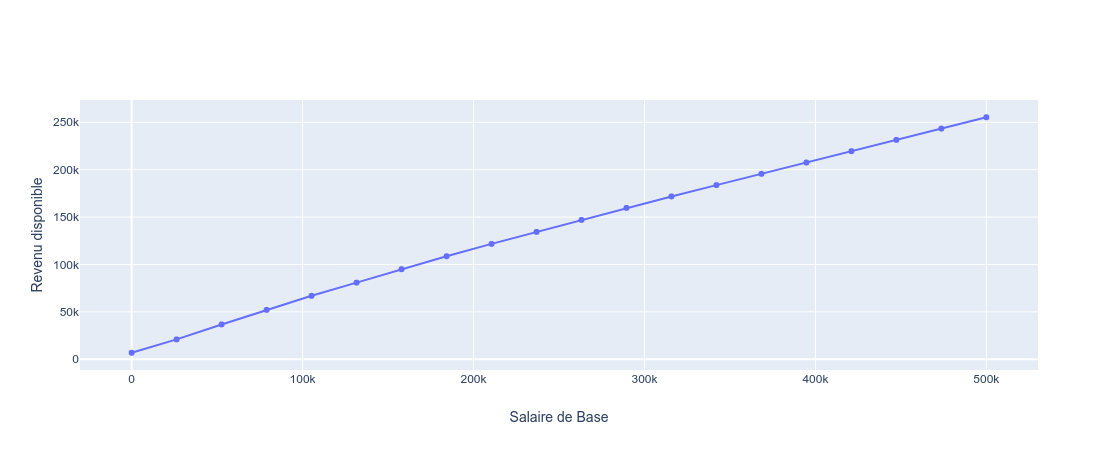

In [43]:
fig = go.Figure(
    data=go.Scatter(x=salaire_de_base, y=revenu_disponible, mode='lines+markers'),
    layout=go.Layout(xaxis_title="Salaire de Base", yaxis_title='Revenu disponible'),
)
fig.show()

## Display interactive waterfall

In [44]:
yaml = YAML(typ='safe')
decomposition = yaml.load(Path("./decomposition.yaml"))
JSON(decomposition)

<IPython.core.display.JSON object>

In [45]:
class BarType(Enum):
    VALUE = 1
    SUB_TOTAL = 2
    TOTAL = 3

@dataclass
class Bar:
    code: str
    type: BarType
    short_name: str = None
    value: float = None

In [47]:
def get_bars(decomposition: dict) -> List[Bar]:
    def visit(node):
        children = node.get("children")
        if children:
            for child in children:
                yield from visit(child)
            type_ = BarType.TOTAL if node["code"] == decomposition["code"] else BarType.SUB_TOTAL
            yield Bar(code=node["code"], short_name=node.get("name"), type=type_)
        else:
            yield Bar(code=node["code"], short_name=node.get("name"), type=BarType.VALUE)

    return list(visit(decomposition))

In [48]:
bars = get_bars(decomposition)
display(bars)

[Bar(code='cout_du_travail', type=<BarType.VALUE: 1>, short_name='Coût du travail', value=None),
 Bar(code='credit_impot_competitivite_emploi', type=<BarType.VALUE: 1>, short_name='CICE', value=None),
 Bar(code='aide_premier_salarie', type=<BarType.VALUE: 1>, short_name='Aide premier salarié', value=None),
 Bar(code='aide_embauche_pme', type=<BarType.VALUE: 1>, short_name='Aide PME', value=None),
 Bar(code='tehr', type=<BarType.VALUE: 1>, short_name='Taxe exceptionnelle', value=None),
 Bar(code='salaire_super_brut', type=<BarType.SUB_TOTAL: 2>, short_name='Salaire super brut', value=None),
 Bar(code='allegement_fillon', type=<BarType.VALUE: 1>, short_name='Fillon', value=None),
 Bar(code='salaire_super_brut_hors_allegements', type=<BarType.SUB_TOTAL: 2>, short_name='Salaire super brut HA', value=None),
 Bar(code='cotisations_employeur', type=<BarType.VALUE: 1>, short_name='Cotisations employeur', value=None),
 Bar(code='salaire_de_base', type=<BarType.SUB_TOTAL: 2>, short_name='Salaire

In [17]:
def calculate_bars(simulation, period, bars: List[Bar]) -> dict:
    return {
        bar.code: simulation.calculate_add(bar.code, period)
        for bar in bars
    }

In [18]:
results = calculate_bars(simulation, PERIOD, bars)
display(results)

{'cout_du_travail': array([     0.   ,  33683.207,  73096.695, 110859.02 , 147673.8  ,
        182733.88 , 215975.7  , 248185.61 , 280355.44 , 312525.5  ,
        344695.66 , 376865.7  , 409035.53 , 441205.62 , 473375.44 ,
        505545.5  , 537715.56 , 569885.4  , 602055.56 , 634225.56 ],
       dtype=float32),
 'credit_impot_competitivite_emploi': array([   0.    , 1578.9476,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,    0.    ,    0.    ,
           0.    ,    0.    ], dtype=float32),
 'aide_premier_salarie': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 'aide_embauche_pme': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 'tehr': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dty

In [19]:
def iter_bars_with_value_at_index(bars, results, index, include_zero=False):
    for bar in bars:
        value = results[bar.code][index]
        if include_zero or value != 0:
            yield dataclasses.replace(bar, value=value)

In [20]:
def iter_displayed_bars(bars: List[Bar], results: dict, index: int, include_subtotals: bool = True):
    displayed_bars = filter(lambda bar: include_subtotals or bar.type != BarType.SUB_TOTAL, bars)
    displayed_bars = iter_bars_with_value_at_index(displayed_bars, results, index)
    yield from displayed_bars

In [21]:
def create_waterfall(bars, results, title="Waterfall"):
    def update_plot(*args):
        index = value_to_index(MIN, STEP, slider.value)
        displayed_bars = list(iter_displayed_bars(bars, results, index, include_subtotals.value))
        with fig.batch_update():
            waterfall = fig.data[0]
            waterfall.x = [bar.name or bar.code for bar in displayed_bars]
            waterfall.y = [
                bar.value if bar.type == BarType.VALUE else 0
                for bar in displayed_bars
            ]
            waterfall.measure = [
                "relative" if bar.type == BarType.VALUE else "total"
                for bar in displayed_bars
            ]
            waterfall.text = [
                ("{:+.0f}" if bar.type == BarType.VALUE else "{:.0f}").format(bar.value)
                for bar in displayed_bars
            ]

    include_subtotals = widgets.Checkbox(description="Include subtotals")
    include_subtotals.observe(update_plot, 'value')

    slider = widgets.FloatSlider(min=MIN, max=MAX, step=STEP, value=INITIAL_VALUE)
    slider.observe(update_plot, 'value')

    waterfall = go.Waterfall(textposition="inside")
    layout = go.Layout(title=title)
    fig = go.FigureWidget(data=[waterfall], layout=layout)
    update_plot()

    return widgets.VBox([
        widgets.HBox([widgets.Label('Salaire de base'), slider]),
        include_subtotals,
        fig,
    ])

In [22]:
create_waterfall(bars, results)

## Display bareme

In [36]:
salaire_de_base

array([     0.  ,  26315.79,  52631.58,  78947.35, 105263.16, 131578.95,
       157894.7 , 184210.52, 210526.31, 236842.11, 263157.9 , 289473.72,
       315789.4 , 342105.25, 368421.03, 394736.9 , 421052.62, 447368.34,
       473684.22, 499999.97], dtype=float32)

In [37]:
revenu_disponible

array([  6842.9014,  20938.236 ,  36725.566 ,  52096.598 ,  66908.65  ,
        80834.96  ,  95010.164 , 108656.71  , 121676.52  , 134345.4   ,
       147013.38  , 159682.22  , 171763.5   , 183699.66  , 195634.92  ,
       207571.22  , 219506.5   , 231442.7   , 243378.02  , 255314.3   ],
      dtype=float32)

In [39]:
results['rsa']

array([6690.451,  550.93 ,  550.93 ,  550.93 ,  550.93 ,  550.93 ,
        550.93 ,  550.93 ,  550.93 ,  550.93 ,  550.93 ,  550.93 ,
        550.93 ,  550.93 ,  550.93 ,  550.93 ,  550.93 ,  550.93 ,
        550.93 ,  550.93 ], dtype=float32)

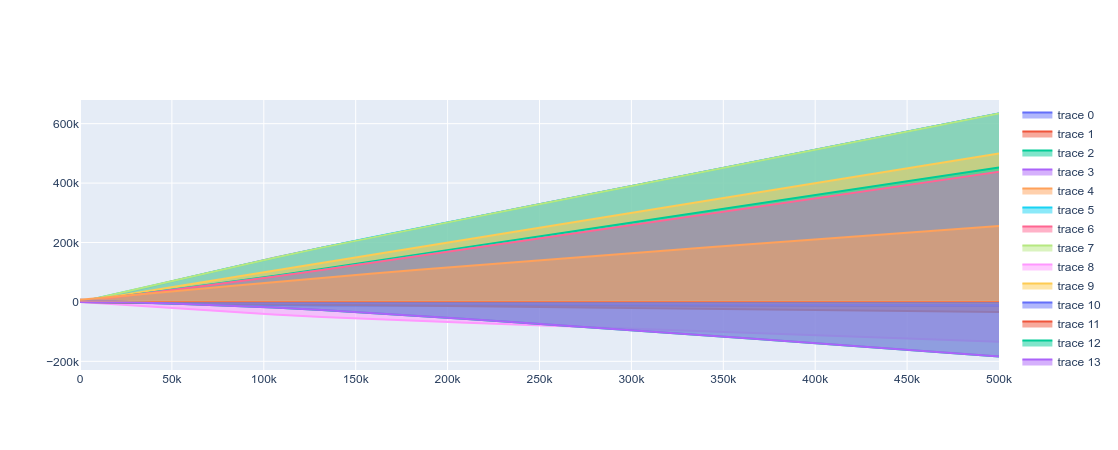

In [41]:
data = [
    go.Scatter(
        x=salaire_de_base,
        y=result,
        fill='tozeroy',
    #     fillcolor='darkviolet',
        hoveron = 'points+fills', # select where hover is active
        text=variable_name,
        hoverinfo = 'text+x+y')
    for variable_name, result in results.items()
]
fig = go.Figure(data=data)
fig.show()